In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pickle

In [2]:
### Load data
df = pd.read_csv('train_dataset.csv', sep=",")
df = df.dropna()

y = df["type"]
X = df.drop(columns=["type"])

/var/folders/nd/w5k06k917hbg7rpdv3ty357c0000gn/T/ipykernel_54668/3959855833.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_dataset.csv', sep=",")


In [3]:
## Encoding
from sklearn import preprocessing

# X
le = preprocessing.OrdinalEncoder()
le.fit(X)
X = le.transform(X)
# y
le = preprocessing.LabelEncoder()
le.fit(y)
y_enc = le.transform(y)


### Split data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, random_state=42)

TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['int', 'str']

Voglio applicare PCA però devo prima standardizzare i dati.
Per standardizzare i dati devo prima encodare quelli categorici

In [13]:
### Look at the dataset
from sklearn import decomposition

## Scaling
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

## PCA
pca = decomposition.PCA()
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_val_pca = pca.transform(X_val_std)

## LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_std, y_train)
X_train_lda = lda.transform(X_train_std)
X_val_lda = lda.transform(X_val_std)

print("Dataset number of classes: ", len(np.unique(y_train)))
print("LDA number of output dimensions: ", X_train_lda.shape[1])

Dataset number of classes:  10
LDA number of output dimensions:  9


---

In [ ]:
### KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

### KNN
best_score = 0
best_k = -1

for k in np.arange(1,30,2):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    score = clf.score(X_val, y_val)
    # print("Val set accuracy with K={:d}: {:.4f}".format(k,score))
    if best_score < score:
        best_score = score
        best_k = k
print("\nBest K = {:d} with score = {:.4f}".format(best_k, best_score))

### KNN with PCA
best_score = 0
best_k = -1

for k in np.arange(1,30,2):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_pca, y_train)
    score = clf.score(X_val_pca, y_val)
    # print("(PCA) Val set accuracy with K={:d}: {:.4f}".format(k,score))
    if best_score < score:
        best_score = score
        best_k = k
print("\nBest K = {:d} with score = {:.4f}".format(best_k, best_score))

### KNN with LDA
best_score = 0
best_k = -1

for k in np.arange(1,30,2):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_lda, y_train)
    score = clf.score(X_val_lda, y_val)
    # print("(PCA) Val set accuracy with K={:d}: {:.4f}".format(k,score))
    if best_score < score:
        best_score = score
        best_k = k
print("\nBest K = {:d} with score = {:.4f}".format(best_k, best_score))



Best K = 13 with score = 0.7218

Best K = 7 with score = 0.7068

Best K = 15 with score = 0.7293


In [ ]:
### Save the model 
# The best result is with LDA and k=15

clf = KNeighborsClassifier(n_neighbors=15)
clf.fit(X_train_lda, y_train)
### SAVE ???

---

Random Forest accuracy: 0.7218


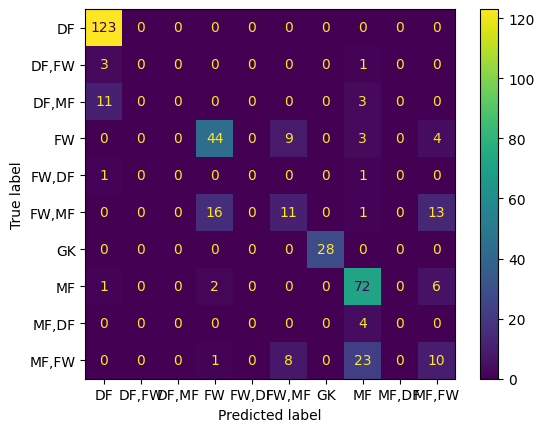

In [14]:
### Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print("Random Forest accuracy: {:.4f}".format(rf.score(X_val, y_val)))

cm = confusion_matrix(y_val, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

Random Forest accuracy: 0.6792


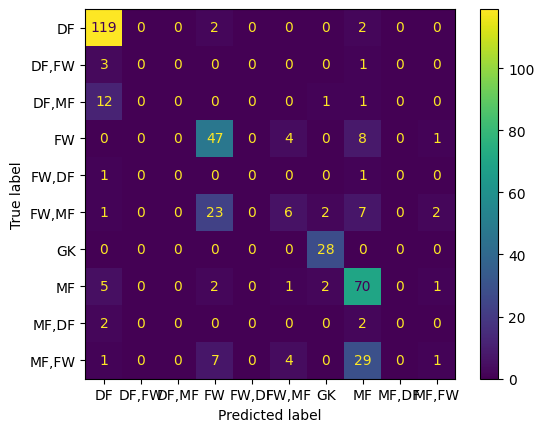

In [15]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_pca, y_train)
y_pred = rf.predict(X_val_pca)
print("Random Forest accuracy: {:.4f}".format(rf.score(X_val_pca, y_val)))

cm = confusion_matrix(y_val, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

Random Forest accuracy: 0.7018


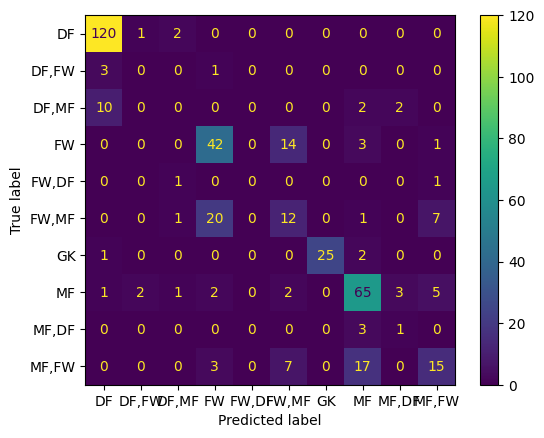

In [16]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_lda, y_train)
y_pred = rf.predict(X_val_lda)
print("Random Forest accuracy: {:.4f}".format(rf.score(X_val_lda, y_val)))

cm = confusion_matrix(y_val, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

---

In [19]:
### SVM classifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ["linear", "poly"]}  
  
grid = GridSearchCV(SVC(), param_grid)
grid.fit(X_train, y_train)
print("SVM accuracy: {:.4f}".format(grid.score(X_val, y_val)))
print("Best parameters: ", grid.best_params_)

SVM accuracy: 0.7193
Best parameters:  {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}


In [20]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ["linear", "poly"]}  
  
grid = GridSearchCV(SVC(), param_grid)
grid.fit(X_train_pca, y_train)
print("SVM accuracy: {:.4f}".format(grid.score(X_val_pca, y_val)))
print("Best parameters: ", grid.best_params_)

SVM accuracy: 0.6942
Best parameters:  {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}


In [21]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ["linear", "poly"]}  
  
grid = GridSearchCV(SVC(), param_grid)
grid.fit(X_train_lda, y_train)
print("SVM accuracy: {:.4f}".format(grid.score(X_val_lda, y_val)))
print("Best parameters: ", grid.best_params_)

SVM accuracy: 0.7018
Best parameters:  {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


---

In [19]:
### FF Classifier
import random
import os
import time

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter

In [2]:
# For reproducibility
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

seed = 42

In [3]:
# Define the Data Layer        
class MyDataset(Dataset):
    def __init__(self, X, y):
        
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
         
        self.num_features = X.shape[1]
        self.num_classes = len(np.unique(y))
       

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [4]:
# define a function with different normalization and scaling techniques
def preprocess(X_train, X_val, modality):
    
    X_train_p, X_val_p = X_train, X_val

    if modality == 'l2' or modality == 'l1':
        X_train_p = preprocessing.normalize(X_train, norm=modality)
        X_val_p = preprocessing.normalize(X_test, norm=modality)

    if modality == 'standard' or modality == 'min-max':
        if modality == 'standard':
            scaler = preprocessing.StandardScaler()
            scaler.fit(X_train)
        elif modality == 'min-max':
            scaler = preprocessing.MinMaxScaler()
            scaler.fit(X_train)
        
        X_train_p = scaler.transform(X_train)
        X_val_p = scaler.transform(X_val)
        
    return X_train_p, X_val_p

In [5]:
# Architecture

class FeedForwardPlus(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size, depth=1, batch_norm=False, drop=0):
        super(FeedForwardPlus, self).__init__()
        
        model = []
        model += [nn.Linear(input_size, hidden_size)]
        if batch_norm:
            model += [nn.BatchNorm1d(hidden_size)]
        model += [nn.ReLU()]

        block = [
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        ]

        block_batch_norm = [
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        ]

        block_dropout = [
            nn.Dropout(drop),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        ]

        for i in range(depth):
            if not batch_norm and drop == 0:
                model += block
            elif batch_norm and drop == 0:
                model += block_batch_norm
            elif drop > 0 and not batch_norm:
                model += block_dropout
        
        self.model = nn.Sequential(*model)
        
        self.output = nn.Linear(hidden_size, num_classes)
        

    def forward(self, x):
        h = self.model(x)
        out = self.output(h)
        return out

In [6]:
# Define a function for the training process

def train_model(model, criterion, optimizer, epoch, scheduler, train_loader, val_loader, device, writer, log_name="model"):
    n_iter = 0
    best_valid_loss = float('inf')
    for epoch in range(epoch):
        model.train()
        
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)  # why here?
            
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(data)

            # Compute Loss
            loss = criterion(y_pred, targets)
            writer.add_scalar("Loss/train", loss, n_iter)

            # Backward pass
            loss.backward()
            optimizer.step()

            n_iter += 1
        
        labels, _, y_pred = test_model(model, val_loader, device)
        loss_val = criterion(y_pred, labels)
        writer.add_scalar("Loss/val", loss_val, epoch)
        
        # save best model
        if loss_val.item() < best_valid_loss:
            best_valid_loss = loss_val.item()
            if not os.path.exists('models'):
                os.makedirs('models')
            torch.save(model.state_dict(), 'models/'+log_name)
        
        writer.add_scalar("hparam/Learning Rate", scheduler.get_last_lr()[0], epoch)
        
        scheduler.step()
            
    return model, best_valid_loss

In [ ]:
# Define a function to evaluate the performance on validation and test sets

def test_model(model, data_loader, device):
    model.eval()
    y_pred = []
    
    for data, targets in data_loader:
        data, targets = data.to(device), targets.to(device)
        y_pred += model(data)
        #print(y_pred)
    
    y_pred = torch.stack(y_pred).squeeze()
    y_pred_c = y_pred.argmax(dim=1, keepdim=True).squeeze()
    
    return y_pred_c, y_pred

In [8]:
# look for GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')
print("Device: {}".format(device))

Device: mps


In [17]:
# Scale data
modality = "min-max"
X_train, X_val = preprocess(X_train, X_val, modality)


# Create the dataset
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)

In [22]:
start = time.time()

# hyperparatemeters 
batch_size = 16
depth = 2
hidden_size = 16
batch_norm = True
drop = 0
num_epochs = 100  # try 100, 200, 500
learning_rate = 0.01
gamma=0.5
step_size=25
log_name = "B"+str(batch_size)+"-dim"+str(hidden_size)+"-dp"+str(depth)+"-ep"+str(num_epochs)+"-lr"+str(learning_rate)+"-steplr"+str(step_size)+"-gamma"+str(gamma)+"-BN"+str(batch_norm)+"-drop"+str(drop)

# fix the seed for reproducibility
fix_random(seed)


# Create relative dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


# Define the architecture, loss and optimizer
model = FeedForwardPlus(train_dataset.num_features, train_dataset.num_classes, hidden_size, depth, batch_norm=batch_norm, drop=drop)
print(model)
model.to(device)


# Define the training elements
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


# Test before the training
y_test, y_pred_c, _ = test_model(model, val_loader, device)
acc = (y_test == y_pred_c).float().sum() / y_test.shape[0]
print("Accuracy before training:", acc.cpu().numpy())


# Start tensorboard
writer = SummaryWriter('runs/'+log_name)


# Train the model 
model = train_model(model, criterion, optimizer, num_epochs, scheduler, train_loader, val_loader, device, writer, log_name)


# Load best model
model.load_state_dict(torch.load("models/"+log_name, weights_only=True))
model.to(device)


# Test after the training
y_test, y_pred_c, _ = test_model(model, test_loader, device)
acc = (y_test == y_pred_c).float().sum() / y_test.shape[0]
print("Accuracy after training:", acc.cpu().numpy())


# Close tensorboard writer after a training
writer.flush()
writer.close()

# Save timestamp
end = time.time()
print("Time elapsed:", end - start)

FeedForwardPlus(
  (model): Sequential(
    (0): Linear(in_features=398, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (output): Linear(in_features=16, out_features=10, bias=True)
)


ValueError: not enough values to unpack (expected 3, got 2)